In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import json
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Directories where your input images are located (train, test, and validation)
train_dir = r"F:\Thesis\0.WorkHere\Train"
test_dir = r"F:\Thesis\0.WorkHere\Test"
validation_dir = r"F:\Thesis\0.WorkHere\Validation"

# Directory to save models and history
save_dir = r"F:\Thesis\0.WorkHere\SavedModels"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)



In [6]:
# Set hyperparameters
batch_size = 5
num_classes = 169
epochs = 20



In [7]:
# Create data generators for image preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Rescale pixel values to [0, 1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Only rescale for testing

# Create data generators for training, testing, and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),  # InceptionV3 input size
    batch_size=batch_size,
    class_mode='categorical'  # Use categorical for multi-class classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical'
)



Found 5530 images belonging to 169 classes.
Found 568 images belonging to 169 classes.
Found 986 images belonging to 169 classes.


In [5]:
# Load the pre-trained InceptionV3 model
base_model_InceptionV3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Create a custom top classifier for the number of classes
model_InceptionV3 = models.Sequential()
model_InceptionV3.add(base_model_InceptionV3)
model_InceptionV3.add(layers.GlobalAveragePooling2D())
model_InceptionV3.add(layers.Dense(1024, activation='relu'))
model_InceptionV3.add(layers.Dropout(0.5))
model_InceptionV3.add(layers.Dense(num_classes, activation='softmax'))

model_InceptionV3.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 169)               173225    
                                                                 
Total params: 24,074,185
Trainable params: 24,039,753
Non-trainable params: 34,432
_______________________________________

In [6]:

model_InceptionV3.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



In [7]:
# Define the checkpoint callback to save the model
checkpoint = ModelCheckpoint(
    filepath=os.path.join(save_dir, 'InceptionV3_model.h5'),
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model
history_InceptionV3 = model_InceptionV3.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[checkpoint]
)



Epoch 1/20
1106/1106 [==============================] - ETA: 0s - loss: 4.0354 - accuracy: 0.1803
Epoch 1: val_loss improved from inf to 1.78633, saving model to F:\Thesis\0.WorkHere\SavedModels\InceptionV3_model.h5
1106/1106 [==============================] - 98s 80ms/step - loss: 4.0354 - accuracy: 0.1803 - val_loss: 1.7863 - val_accuracy: 0.5909
Epoch 2/20
1106/1106 [==============================] - ETA: 0s - loss: 1.4145 - accuracy: 0.6720
Epoch 2: val_loss improved from 1.78633 to 0.20065, saving model to F:\Thesis\0.WorkHere\SavedModels\InceptionV3_model.h5
1106/1106 [==============================] - 94s 85ms/step - loss: 1.4145 - accuracy: 0.6720 - val_loss: 0.2006 - val_accuracy: 0.9442
Epoch 3/20
1106/1106 [==============================] - ETA: 0s - loss: 0.4852 - accuracy: 0.8897
Epoch 3: val_loss improved from 0.20065 to 0.09321, saving model to F:\Thesis\0.WorkHere\SavedModels\InceptionV3_model.h5
1106/1106 [==============================] - 91s 82ms/step - loss: 0.4852 

In [10]:
# Save the training history
history_path = os.path.join(save_dir, 'InceptionV3_history.json')
with open(history_path, 'w') as f:
    json.dump(history_InceptionV3.history, f)

print(f"Model and training history saved in {save_dir}")


Model and training history saved in F:\Thesis\0.WorkHere\SavedModels


In [11]:
# Load the model and history for evaluation without retraining
from tensorflow.keras.models import load_model

model_InceptionV3_loaded = load_model(save_dir + '/InceptionV3_model.h5')




In [12]:
# Load the history
with open(save_dir + '/InceptionV3_history.json', 'r') as f:
    history_InceptionV3_loaded = json.load(f)


In [16]:
# Evaluate the model on the test data
test_loss, test_acc = model_InceptionV3_loaded.evaluate(test_generator)
print(f'Test accuracy InceptionV3: {test_acc * 100:.2f}%')

# Evaluate the model on the validation data
validation_loss, validation_acc = model_InceptionV3_loaded.evaluate(validation_generator)
print(f'Validation accuracy InceptionV3: {validation_acc * 100:.2f}%')


114/114 [==============================] - 3s 24ms/step - loss: 0.0228 - accuracy: 0.9894
Test accuracy InceptionV3: 98.94%
198/198 [==============================] - 5s 24ms/step - loss: 0.0131 - accuracy: 0.9939
Validation accuracy InceptionV3: 99.39%


In [17]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Generate predictions
predictions = model_InceptionV3_loaded.predict(test_generator)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels from the test set generator
true_labels = test_generator.classes

# Get class labels (optional, but useful for the classification report)
class_labels = list(test_generator.class_indices.keys())

# Ensure the classification report and confusion matrix consider all classes
labels = list(test_generator.class_indices.values())

# Print classification report
print(classification_report(true_labels, predicted_labels, labels=labels, target_names=class_labels, zero_division=1))

# Print confusion matrix
print(confusion_matrix(true_labels, predicted_labels, labels=labels))


114/114 [==============================] - 4s 24ms/step
              precision    recall  f1-score   support

       cow_1       0.00      0.00      0.00         2
      cow_10       0.00      0.00      0.00         4
     cow_101       0.00      0.00      0.00         2
     cow_110       0.00      0.00      0.00         2
     cow_112       0.00      0.00      0.00         4
     cow_113       0.00      0.00      0.00         4
     cow_118       0.00      0.00      0.00         2
     cow_119       0.00      0.00      0.00         4
     cow_120       0.00      0.00      0.00         4
     cow_121       0.00      0.00      0.00         4
     cow_122       0.00      0.00      0.00         4
     cow_123       0.00      0.00      0.00         6
     cow_124       0.00      0.00      0.00         4
     cow_126       0.00      0.00      0.00         4
     cow_127       0.00      0.00      0.00         6
     cow_129       0.00      0.00      0.00         2
      cow_13       0.00  

114/114 [==============================] - 3s 24ms/step


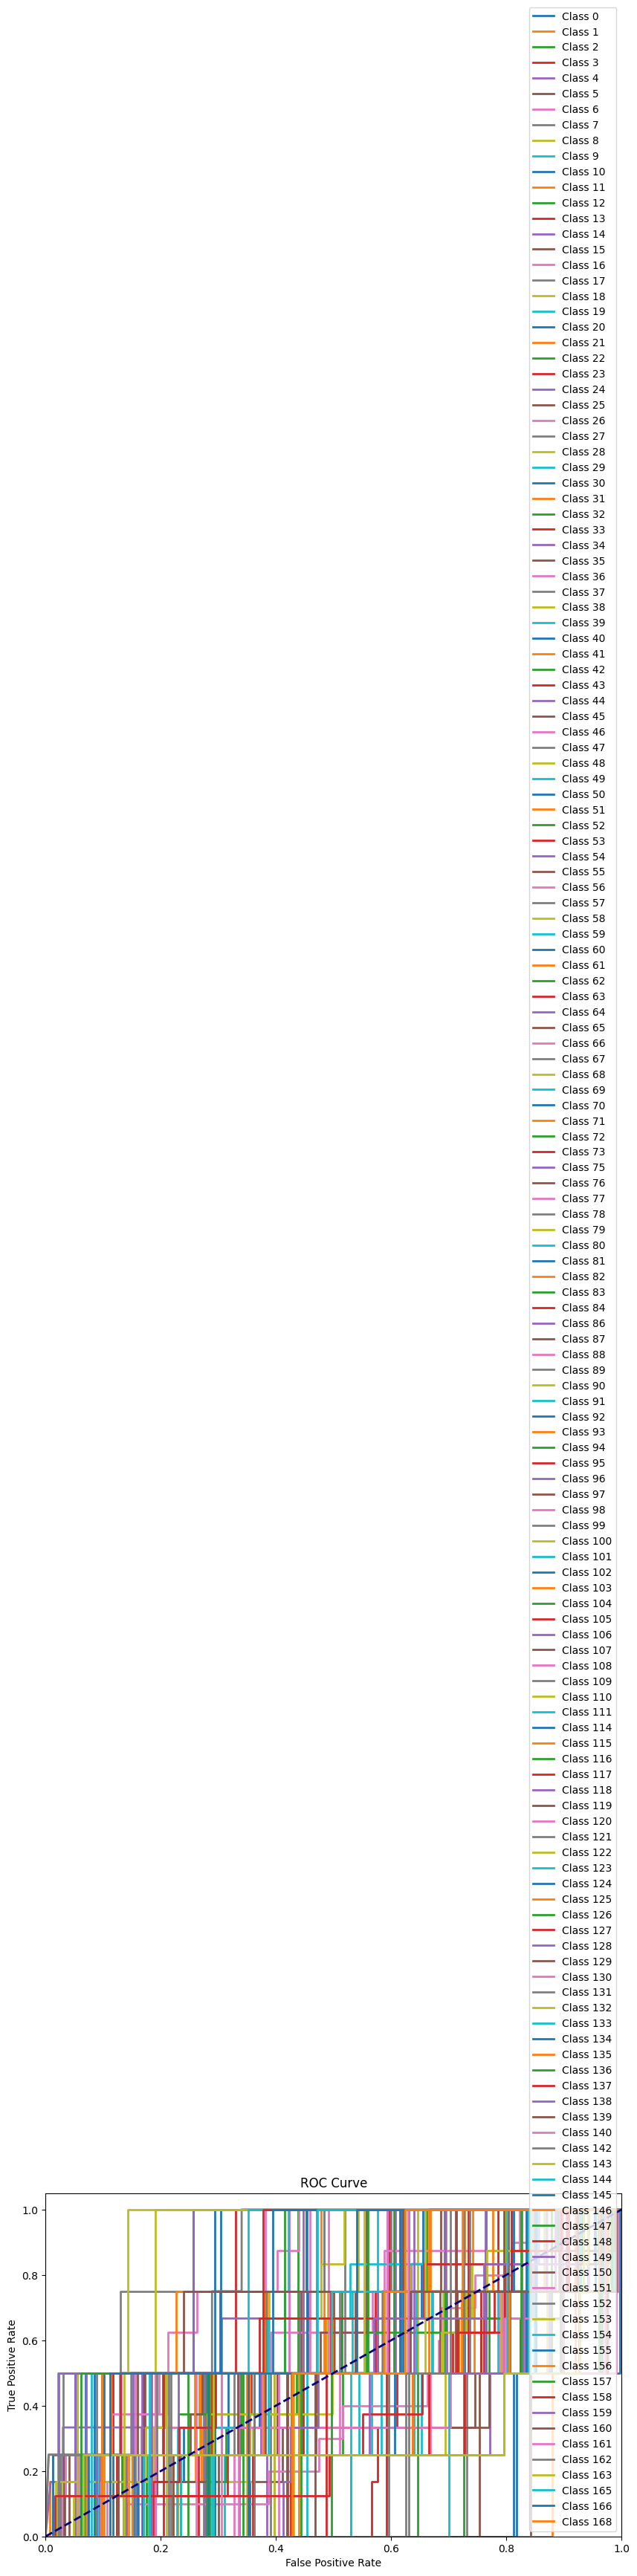

In [18]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Assuming you have test labels and predicted probabilities
y_true = test_generator.classes
y_pred = model_InceptionV3_loaded.predict(test_generator)

# Plot ROC curve for each class
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    if sum(y_true == i) > 0:  # Check if there are positive samples for class i
        fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_pred[:, i])
        plt.plot(fpr, tpr, lw=2, label=f'Class {i}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


114/114 [==============================] - 3s 25ms/step


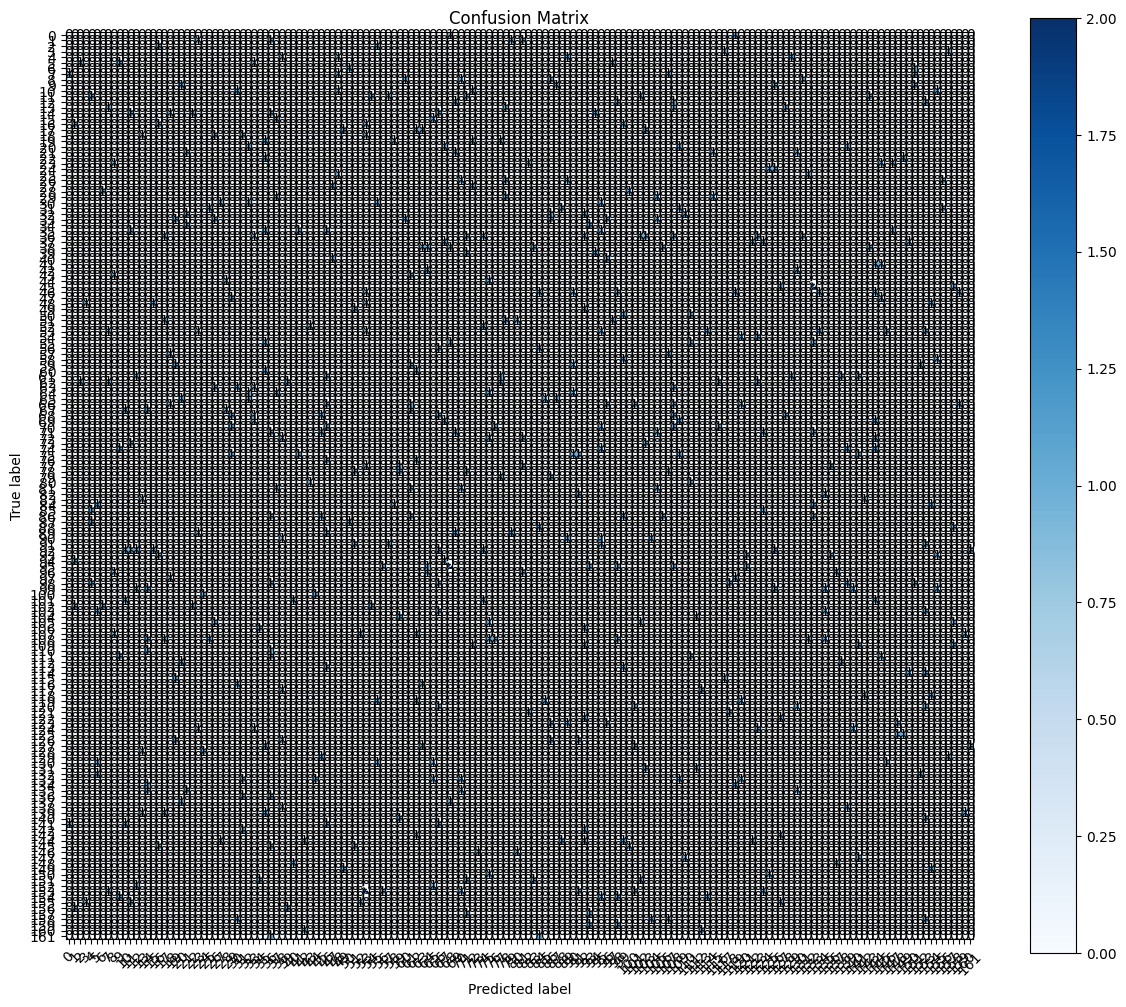

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have true labels (y_true) and predicted labels (y_pred)
# Replace with the actual true and predicted labels
y_true = test_generator.classes
y_pred = model_InceptionV3_loaded.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
confusion = confusion_matrix(y_true, y_pred)

# Define class labels
class_labels = list(range(confusion.shape[0]))  # Assuming class labels are integers from 0 to 84

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

thresh = confusion.max() / 2.0
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j, i, f"{confusion[i, j]}", ha="center", va="center", color="white" if confusion[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()


In [20]:
import numpy as np
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split


# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Cross-Validation Accuracy:", accuracy)

Cross-Validation Accuracy: 0.0035211267605633804


In [22]:
import numpy as np
from sklearn.metrics import f1_score

# Assuming you have true labels (y_true) and predicted labels (y_pred)
# Replace with the actual true labels and predicted labels
y_true = test_generator.classes
y_pred = model_InceptionV3_loaded.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Compute the F1 score
f1 = f1_score(y_true, y_pred, average='weighted')  # You can choose the averaging strategy you need

print(f'Weighted F1 Score: {f1:.2f}')


114/114 [==============================] - 3s 24ms/step
Weighted F1 Score: 0.00


In [24]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size=(299, 299)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale pixel values to [0, 1]
    return img_array

# Load the pre-trained model
model_path = os.path.join(save_dir, 'InceptionV3_model.h5')
model_InceptionV3_loaded = tf.keras.models.load_model(model_path)

# Path to the image to predict
img_path = r"F:\Thesis\0.WorkHere\Test\cow_10\cow_10_18.jpg"

# Preprocess the image
preprocessed_img = load_and_preprocess_image(img_path)

# Make the prediction
prediction = model_InceptionV3_loaded.predict(preprocessed_img)

# Print the prediction
print(prediction)


1/1 [==============================] - 1s 862ms/step
[[2.13301638e-24 1.00000000e+00 1.23520762e-22 1.67140151e-26
  7.00687334e-23 1.54031008e-23 2.32681928e-21 7.49900454e-23
  2.04267729e-20 7.21915720e-22 5.37190484e-23 8.07244106e-21
  1.30734587e-20 1.99881450e-23 3.06036932e-27 6.96240368e-23
  9.01530556e-25 5.54343701e-25 2.78582927e-19 1.90973022e-21
  2.10457901e-27 1.16773875e-19 4.66695350e-26 1.57431393e-22
  2.56304419e-24 3.80039337e-25 2.35633566e-25 4.00000252e-23
  1.84396213e-28 4.79302778e-21 8.37875745e-27 1.70695351e-22
  5.15432476e-21 7.27879817e-16 2.15236545e-22 2.15337796e-20
  1.61721138e-19 7.26937866e-27 1.72713988e-15 4.77840822e-27
  5.02186455e-20 1.29795205e-23 3.38235669e-26 2.07430509e-29
  5.08685994e-20 3.41172536e-16 5.24736117e-17 7.19920440e-26
  2.61608405e-28 6.99673632e-27 1.72061529e-24 2.96477816e-25
  2.76369684e-26 4.73850192e-23 1.42693462e-25 1.20788765e-23
  2.30959642e-18 6.26102063e-22 1.16711477e-20 7.38423537e-23
  7.91621136e-22 

In [25]:
from tensorflow.keras.preprocessing import image
import numpy as np
import os

# Function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size=(299, 299)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale pixel values to [0, 1]
    return img_array

# Load the pre-trained model
model_path = os.path.join(save_dir, 'InceptionV3_model.h5')
model_InceptionV3_loaded = tf.keras.models.load_model(model_path)

# Path to the image to predict
img_path = r"F:\Thesis\0.WorkHere\Test\cow_10\cow_10_18.jpg"

# Preprocess the image
preprocessed_img = load_and_preprocess_image(img_path)

# Make the prediction
prediction = model_InceptionV3_loaded.predict(preprocessed_img)

# Get the class indices from the training generator
class_indices = train_generator.class_indices
# Reverse the class indices to get a mapping from indices to class names
indices_to_class = {v: k for k, v in class_indices.items()}

# Get the predicted class index
predicted_class_index = np.argmax(prediction[0])
# Get the predicted class name
predicted_class_name = indices_to_class[predicted_class_index]

# Print the predicted class name
print(f"Predicted class: {predicted_class_name}")


1/1 [==============================] - 1s 882ms/step
Predicted class: cow_10


In [9]:
from tensorflow.keras.preprocessing import image
import numpy as np
import os

# Function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size=(299, 299)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale pixel values to [0, 1]
    return img_array

# Load the pre-trained model
model_path = os.path.join(save_dir, 'InceptionV3_model.h5')
model_InceptionV3_loaded = tf.keras.models.load_model(model_path)

# Path to the image to predict
img_path = r"F:\Thesis\0.WorkHere\Validation\cow_164\cow_164_3_rot35.jpg"

# Preprocess the image
preprocessed_img = load_and_preprocess_image(img_path)

# Make the prediction
prediction = model_InceptionV3_loaded.predict(preprocessed_img)

# Get the class indices from the training generator
class_indices = train_generator.class_indices
# Reverse the class indices to get a mapping from indices to class names
indices_to_class = {v: k for k, v in class_indices.items()}

# Get the predicted class index
predicted_class_index = np.argmax(prediction[0])
# Get the predicted class name
predicted_class_name = indices_to_class[predicted_class_index]

# Print the predicted class name
print(f"Predicted class: {predicted_class_name}")


1/1 [==============================] - 1s 935ms/step
Predicted class: cow_164


114/114 [==============================] - 3s 23ms/step


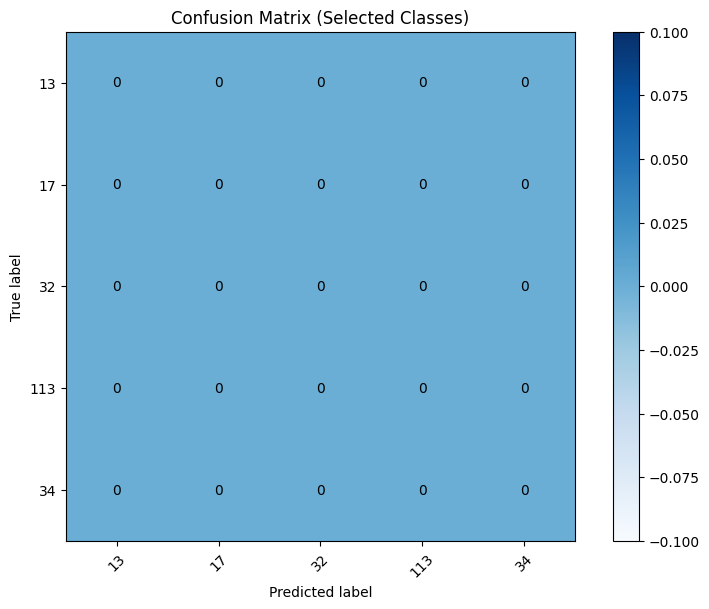

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have true labels (y_true) and predicted labels (y_pred)
# Replace with the actual true and predicted labels
y_true = test_generator.classes
y_pred = model_InceptionV3_loaded.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
confusion = confusion_matrix(y_true, y_pred)

# Define the class labels
class_labels = list(range(confusion.shape[0]))  # Assuming class labels are integers from 0 to 168

# Select a subset of classes (e.g., classes 0, 1, 2, 3, and 4)
selected_classes = [13, 17, 32, 113, 34]  # Change these indices to the classes you want to display
filtered_confusion = confusion[np.ix_(selected_classes, selected_classes)]

# Plot the confusion matrix for the selected classes
plt.figure(figsize=(8, 6))
plt.imshow(filtered_confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Selected Classes)')
plt.colorbar()

tick_marks = np.arange(len(selected_classes))
plt.xticks(tick_marks, selected_classes, rotation=45)
plt.yticks(tick_marks, selected_classes)

thresh = filtered_confusion.max() / 2.0
for i in range(len(selected_classes)):
    for j in range(len(selected_classes)):
        plt.text(j, i, f"{filtered_confusion[i, j]}", ha="center", va="center", 
                 color="white" if filtered_confusion[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()
